In [657]:
import numpy as np
from scipy.stats import truncnorm
import random
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

epoch_for_train=1000 #How long to train
samples_per_epoch=250 #The playground.tensorflow.org has 250 train points (and 250 for test)
train_batch_size = 10 #10 as at the playground
summary_every_epoch = 100 #print loss
layers_sizes = [8, 8, 8, 8, 1] #network configuration: every value is layer size

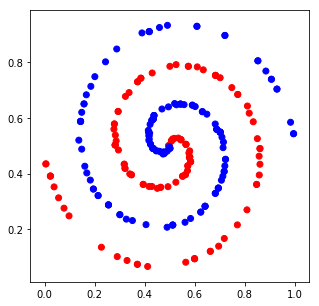

In [658]:
#generating data function - some derivative from playground code
def generate_data(num_of_data):
    xs = np.zeros((num_of_data, 2))
    ys = np.zeros((num_of_data, 1))
    noise=0.01
    size=1

    for i in range(int(num_of_data)):
        if (i%2):    #positive examples
            r = i / num_of_data/2 * size;
            t = 1.75 * i / num_of_data  * math.pi*2;
            xs[i][0] = size/2+r * math.sin(t) + (random.random()-0.5) * noise;
            xs[i][1] = size/2+r * math.cos(t) + (random.random()-0.5) * noise;
            ys[i][0] = 1
        else: #negative examples
            r = i / num_of_data/2 * size;
            t = 1.75 * i / num_of_data  * math.pi*2 +math.pi;
            xs[i][0] = size/2+r * math.sin(t) + (random.random()-0.5) * noise;
            xs[i][1] = size/2+r * math.cos(t) + (random.random()-0.5) * noise;
            ys[i][0] = 0
    return xs, ys


#let's generate: data_x(samples_per_epoch,2) with coordinates of point and data_y(samples_per_epoch,1) with value
data_x, data_y=generate_data(samples_per_epoch)

#function to feed dictionary. Returns a random points from generated data as arrays with batch_size len
dict_index=0
def feed_my_dict(x,y_,batch_size):
    global dict_index
    xs = np.zeros((batch_size, 2))
    ys = np.zeros((batch_size, 1))
    for i in range(batch_size):
        dict_index=int(round(random.random()*(len(data_x[:,0])-1)))
        xs[i][0] = data_x[dict_index,0]
        xs[i][1] = data_x[dict_index,1]
        ys[i][0] = data_y[dict_index,0]
    return {x: xs, y_: ys}


#let's draw generated data
fig, ax = plt.subplots(figsize=(5,5))

#For whole epoch 
for j in range(int(samples_per_epoch/train_batch_size)):
    my_x="x"
    my_y="y"
    #call function that is used for feed tensorflow (to verify it)
    feed_dict=feed_my_dict(my_x,my_y,train_batch_size)
    colors = []
    #to colorize data find max and min y in data
    y_max=np.max(feed_dict[my_y][:,0])
    y_min=np.min(feed_dict[my_y][:,0]) 
    if (y_max!=y_min):
        for i in range(len(feed_dict[my_y][:,0])):#for all batch
            output=(feed_dict[my_y][i,0]-y_min)/(y_max-y_min) #create normalised to 0-1 value
            colors.append((int(output),0,int(1-output)))#color: R-part max when data is '1', B-part max when 0. G always 0
        ax.scatter(feed_dict[my_x][:,0], feed_dict[my_x][:,1], color=colors) #plot all batch points
plt.show()

loss= 0.46
loss= 0.468
loss= 0.476
loss= 0.187157520312
loss= 0.146487241368
loss= 0.101589199565
loss= 0.0923668935719
loss= 0.0512886842052
loss= 0.0275115935848
loss= 0.0414093045643


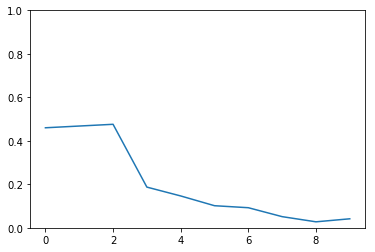

num_of_undied= 12


In [659]:
all_weights = []
all_outputs = []

#generates random with normal distribution and clipped by -1 and 1
def trunc_norm(shape):
    myclip_a = -1
    myclip_b = 1
    my_mean = 0
    my_std = 0.5
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    return truncnorm.rvs(a, b, scale = my_std, size=shape)
    

#init
#Biases implemented as additional weights to 1.0 constant
for n in range(len(layers_sizes)):
    if (n==0): #input layer
        weights_shape = (2+1, layers_sizes[n]) #two inputs plus weight to bias constant
    else:
        weights_shape = (layers_sizes[n-1]+1,layers_sizes[n]) #prev layer size +1 for biases
    weights=trunc_norm(weights_shape) #init
    weights[0,:]=0.1 #biases - first row
    all_weights.append(weights)# array for weights for all layers
    all_outputs.append(np.zeros(layers_sizes[n])) #array for layers outputs

#feed forward pass
def nn_forward(batch):#input - batch of data
    #forward
    for n in range(len(layers_sizes)):#per layer
        if (n==0):
            layer_input = np.array(batch)#for input layer
        else:
            layer_input= all_outputs[n-1]#for other layers input is prev output
        #adding ones to top of inputs for biases
        layer_input_biased=np.ones((np.shape(all_weights[n])[0],np.shape(batch)[1]))
        layer_input_biased[1:,:] =  layer_input #copylefted from https://blog.viktorp.com/2016/01/05/adding-a-bias-column-to-numpy-matrix/
        layer_output = all_weights[n].T.dot(layer_input_biased)#w*x+b  (bias as w[0] element)
        layer_output = np.maximum(layer_output,0)#relu activation
        all_outputs[n]=layer_output
    return all_outputs


#Training
loss_pic=[]
x = "my_x"
y_ = "my_y"
num_of_undied=0
for i in range(epoch_for_train):
    if ((i % summary_every_epoch) == 0):#print loss
        feed_dict=feed_my_dict(x,y_,samples_per_epoch)#batch - all data to minimum noise of loss
        my_outputs=nn_forward(feed_dict[x].T)#feed forward
        y_pred=my_outputs[len(layers_sizes)-1]#output of last layer - our prediction
        loss = np.mean(np.square(feed_dict[y_].T - y_pred))#mean squared loss
        loss_pic.append(loss)#for plot
        print("loss=",loss)

        #trick to make dead relu alive
        for n in range(len(layers_sizes)):# by layers
            for m in range(layers_sizes[n]): #by neurons
                if (max(my_outputs[n][m])<0.00001):#relu is not active in all data batch - it dead
                    all_weights[n][:,m]=trunc_norm(np.shape(all_weights[n][:,m])) #re init it
                    all_weights[n][0,m]=0.1# bias
                    num_of_undied+=1 #dead counter
        
        
    for j in range(int(samples_per_epoch/train_batch_size)):#one train_step run one batch data
        feed_dict=feed_my_dict(x,y_,train_batch_size) #batch data
        my_outputs=nn_forward(feed_dict[x].T)#feed forward
        y_pred=my_outputs[len(layers_sizes)-1] #output of last layer - our prediction
        loss = np.square(feed_dict[y_].T - y_pred) #mean squared error (MSE)
        
        #backward pass
        #this implementation is not goot at all! Very confusing!
        #There are architectural mistake - I make bias as additional weight component to 1.0 constant.
        #This results to overhead of adding and deleting rows from matrices
        grad_y_pred=2*(feed_dict[y_].T - y_pred) #derivative from MSE
        errors=[]
        gradients = []
                
        for n in range(len(layers_sizes)): #for layers count. Go back: n==0 now last layer!
            n_backward=len(layers_sizes)-1-n  #number of layer form end (reversed n)
            if (n_backward==0): #this is input layer
                prev_layer_out=feed_dict[x].T #prev layer output is data
            else:
                prev_layer_out=all_outputs[n_backward-1] #prev layer output
                        
            #we use bias as additional weight
            #for matrix mpy we need to extend prev output layer by adding ones at the top
            #creating array with all 1 with size (out_size+1,batch size)
            prev_layer_out_with_bias=np.ones((np.shape(prev_layer_out)[0]+1,train_batch_size))
            #now replace all data exept tot row to real prev layer output
            prev_layer_out_with_bias[1:,:] =  prev_layer_out #copylefted from https://blog.viktorp.com/2016/01/05/adding-a-bias-column-to-numpy-matrix/

            #prepare output of current layer
            current_layer_out=all_outputs[n_backward]

            #calculating error (derivative of loss for every layer)
            if (n==0):#last layer
                current_error=grad_y_pred.T #error of last layer is directly derivative from loss
                current_layer_out_with_bias=current_layer_out
            else:
                #error for current layer is mpy of prev layer error (errors[-1] is last added value)
                #and transposed weights of next layer
                current_error=errors[-1].dot(all_weights[n_backward+1].T)
                #again prepare output of current layer with ones at the top (for our bias-trick way)
                current_layer_out_with_bias=np.ones((np.shape(current_layer_out)[0]+1,train_batch_size))
                current_layer_out_with_bias[1:,:] =  current_layer_out #copylefted from https://blog.viktorp.com/2016/01/05/adding-a-bias-column-to-numpy-matrix/
 
            #relu derivative - zero if output of current layer is zero
            current_error[(current_layer_out_with_bias<=0).T]=0

            #here get rid of additional row of ones at the top
            if (n==0):#last layer
                error_without_bias_err=current_error
            else:
                error_without_bias_err=current_error[:,1:]

            #put current layer error to safe place for using at next iteration
            errors.append(error_without_bias_err)

            #our weight gradient is dot mpy of prev layer output and current error, normalised by batch size
            grad=(1/train_batch_size)*prev_layer_out_with_bias.dot(current_error)
            
            #againg get rid of additional row of ones at the top
            if (n==0):#last layer
                grad_without_bias_err=grad
            else:
                grad_without_bias_err=grad[:,1:]
            #fuuf, gradients for this layer is ready
            gradients.append(grad_without_bias_err)
            
        #after backward pass let's do a traning of network - updating
        learning_rate=0.05
        for n in range(len(layers_sizes)):
            #it's silly but my gradients here is negative itself and we add theirs to weight instead classical subtraction :-(
            all_weights[n] += learning_rate*(gradients[len(layers_sizes)-1-n])


#let's draw loss picture
fig, ax = plt.subplots()
ax.plot(loss_pic) #plot all batch points
ax.set_ylim([0,1])
plt.show()
print("num_of_undied=",num_of_undied)

    

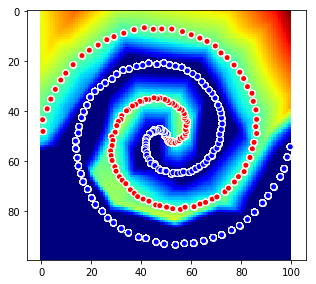

In [662]:
#let's try to draw output picture as at the playground.tensorflow.orgplayground. To do this create a grid as input data
#and give it to our model for calculating 'y' (output). Given 'y' we can draw picture of activation


#special feed dictionry for this - simple grid with some dimension
def feed_dict_for_plot(x,y_,dimension):   
    xs = np.zeros((dimension*dimension, 2))
    ys = np.zeros((dimension*dimension, 1))
    index = 0
    for i in range(dimension):
        for j in range(dimension):
            xs[index][0] = i / dimension
            xs[index][1] = j / dimension
            ys[index][0] = 0 #we do not train the model, so we don't define labels
            index += 1
    return {x: xs, y_: ys}

#resolution for our picture
image_size=100
#feed model our grid
#returned array shape is (image_size^2, 1)
x = "my_x"
y_ = "my_y"
feed_dict=feed_dict_for_plot(x,y_,image_size)
my_outputs=nn_forward(feed_dict[x].T)
output_activation=my_outputs[len(layers_sizes)-1][0]

#Making rgb picture from output data
def out_data_to_rgb(my_y,dimension):
    y_max=np.max(my_y)
    if (y_max==0):
        y_max=0.1
    #normalize output and create color by jet colormap. Color returned with alpha channel, get rid of it by slises
    my_data=cm.jet(my_y/y_max)[:,0:3]
    #flat array to dimension*dimension
    out_picture=np.reshape(my_data,(dimension,dimension,3))
    out_picture=np.transpose(out_picture,(1,0,2))
    return out_picture


#let's draw data at the top
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(out_data_to_rgb(output_activation,image_size))
#finaly add our dataset at the top of picture as reference
colors = []
y_max=np.max(data_y[:,0])
y_min=np.min(data_y[:,0])   
for i in range(len(data_y[:,0])):
    output=(data_y[i,0]-y_min)/(y_max-y_min)
    colors.append((int(output),0,int(1-output)))
    ax.scatter(data_x[:,0]*image_size, data_x[:,1]*image_size, color=colors, edgecolors ='w')
plt.show()



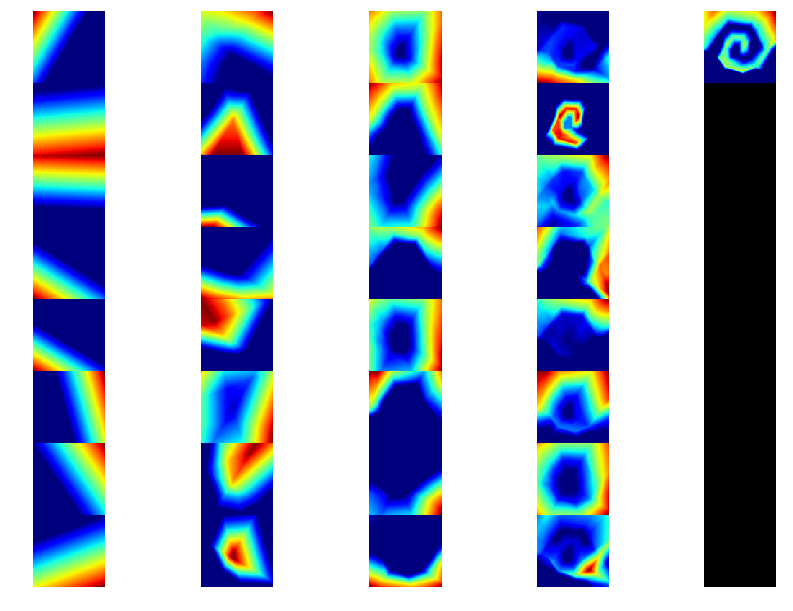

In [663]:
#we have my_outputs - outputs of all neurons
#We can draw it too same way as we draw output before
image_data = []
image_num=0
#create grid of pictures
fig = plt.figure(figsize=(len(layers_sizes)*3, max(layers_sizes)))
gs1 = gridspec.GridSpec(max(layers_sizes), len(layers_sizes))
gs1.update(wspace=0.01, hspace=0.0) # set the spacing between axes.
fig.subplots_adjust(bottom=0.0,  top=1, wspace=0, hspace=0)

for n in range(len(layers_sizes)):# by layers
    for m in range(max(layers_sizes)): #by neurons
        image_num=len(layers_sizes)*m+n
        ax = plt.subplot(gs1[image_num])
        if (m<layers_sizes[n]):
            output_activation=my_outputs[n][m]
            ax.imshow(out_data_to_rgb(output_activation,image_size))
        else:#black picture for layer with less neurons
            ax.imshow(np.zeros([image_size, image_size, 3]))
        ax.axis('off')  # clear x- and y-axes
plt.show()
